# Over-sampling with cross-validation
When we train a classifier, we want it to predict an outcome in a real life dataset. Thus, it is important to evaluate the performance of the classifier on a data set with the original distribution of classes, and not on the rebalanced data.

This means, that the over-sampling methods should be performed on the dataset that we are going to use to train the classifier. But, the performance of the model should be determined on a portion of the data, that was not re-sampled.

In this notebook, we will use the imbalanced-learn pipeline, to set up various over-sampling solutions in a way that we train the model on re-sampled data, but we evaluate performance on non-resampled data.

In [10]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from imblearn.datasets import fetch_datasets
from imblearn.pipeline import make_pipeline

from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE,
)

In [2]:
oversampler_dict = {
    'random': RandomOverSampler(
        sampling_strategy='auto',
        random_state=0),

    'smote': SMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        ),

    'adasyn': ADASYN(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        n_neighbors=5,
        ),

    'border1': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1',
        ),

    'border2': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-2',
        ),

    'svm': SVMSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        svm_estimator=SVC(kernel='linear')),
}

In [3]:
dataset_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level'
]

In [4]:
# print class imbalance
for dataset in dataset_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})

thyroid_sick
Counter({-1: 3541, 1: 231})

arrhythmia
Counter({-1: 427, 1: 25})

ozone_level
Counter({-1: 2463, 1: 73})



In [6]:
# function to train random forest and evaluate the performance
# with cross-validation
def run_model(X_train, y_train, oversampler=None):
    # set up classifier
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=39,
        max_depth=3,
        n_jobs=4
    )

    # setup a scaler
    scaler = MinMaxScaler()
    
    #without sampling
    if not oversampler:
        model = rf
    # set up a pipeline with sampling
    else:
        # important to scale before resampler
        # as many of the methods require the variables in a similar scale
        model = make_pipeline(
            scaler,
            oversampler,
            rf,
        )

    # when we make a pipeline and then run the training of the model with cv,
    # the procedure works as follows:
    # 1) take 2 of the 3 fold as train set
    # 2) resample the 2 fold (aka, the train set)
    # 3) train the model on the resampled data from point 2
    # 4) evaluate performance on the 3rd fold, that was not resampled
    
    # this way, we make sure that we are not evaluating the performance
    # of our classifier on the over-sampled data

    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        scoring='average_precision',
        cv=3
    )

    print(
        'Random Forests average precision: {0} +/- {1}'.format(
        cv_results['test_score'].mean(), cv_results['test_score'].std()
        )
    )

    return cv_results['test_score'].mean(), cv_results['test_score'].std()

In [7]:
# now we train several models with the different oversamplers and with cv
# for each dataset

# to save results
pr_mean_dict = {}
pr_std_dict = {}

for dataset in dataset_ls:
    # initiate a dict for each dataset
    pr_mean_dict[dataset] = {}
    pr_std_dict[dataset] = {}

    print(dataset)

    # load dataset
    data = fetch_datasets()[dataset]

    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        data.data,
        data.target,
        test_size=0.3,
        random_state=0
    )

    # train model on data without resampling
    aps_mean, aps_std = run_model(X_train, y_train)

    # store results
    pr_mean_dict[dataset]['full_data'] = aps_mean
    pr_std_dict[dataset]['full_data'] = aps_std

    print()

    for oversampler in oversampler_dict.keys():
        print(oversampler)

        # resample, train and evaluate performance
        # with cv
        aps_mean, aps_std = run_model(X_train, y_train, oversampler=oversampler_dict[oversampler])

        # store results
        pr_mean_dict[dataset][oversampler] = aps_mean
        pr_std_dict[dataset][oversampler] = aps_std

        print()

    print()

car_eval_34
Random Forests average precision: 0.7481090731569603 +/- 0.0640047618385711

random
Random Forests average precision: 0.8433408505659911 +/- 0.07516648844294718

smote
Random Forests average precision: 0.7996390750105542 +/- 0.05299447011827732

adasyn
Random Forests average precision: 0.8507831066987245 +/- 0.06309165593331685

border1
Random Forests average precision: 0.82633809985363 +/- 0.04178155813555881

border2
Random Forests average precision: 0.8520344458595729 +/- 0.05814446525496678

svm
Random Forests average precision: 0.6979319354440366 +/- 0.05899389197038548


ecoli
Random Forests average precision: 0.6687434616841758 +/- 0.11512585309131046

random
Random Forests average precision: 0.5853702816801476 +/- 0.01634245823762112

smote
Random Forests average precision: 0.590252824084061 +/- 0.05876172398967219

adasyn
Random Forests average precision: 0.5798786475869809 +/- 0.022512165969597202

border1
Random Forests average precision: 0.5823857212746102 +/- 0

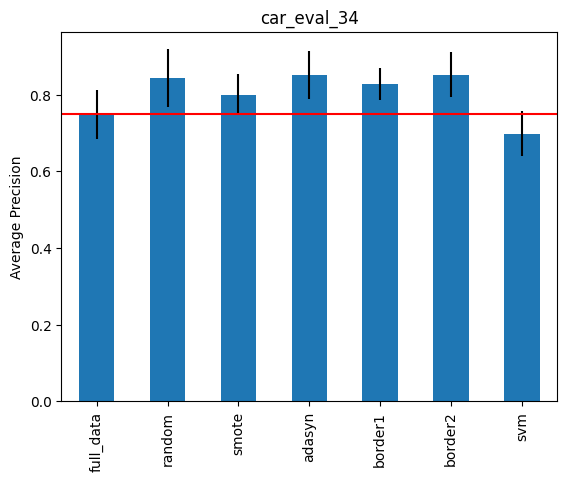

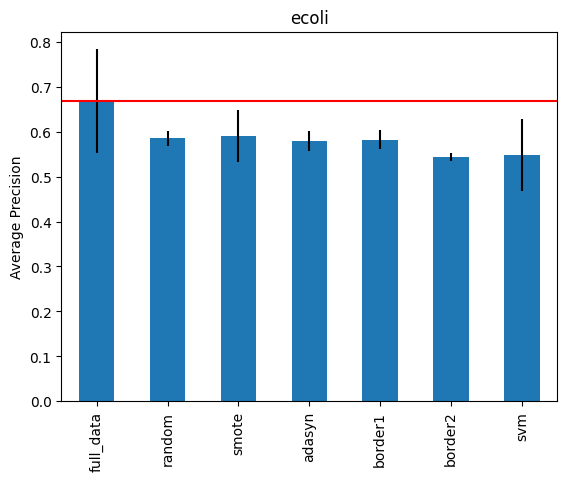

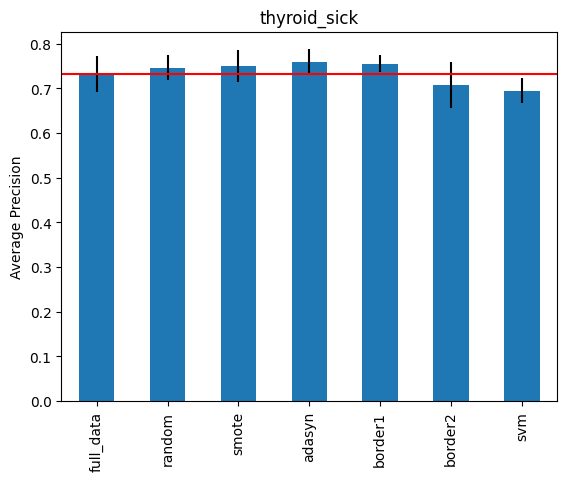

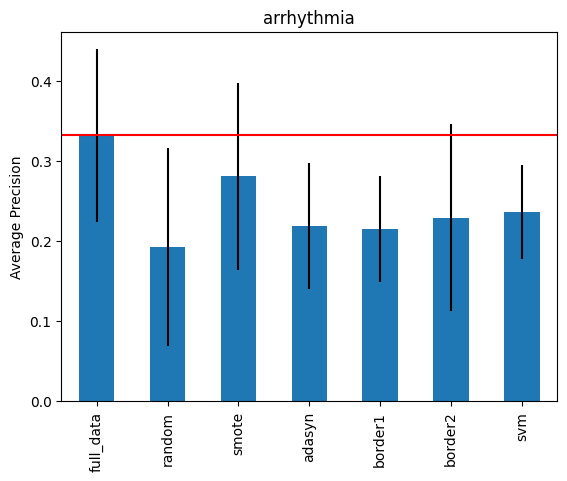

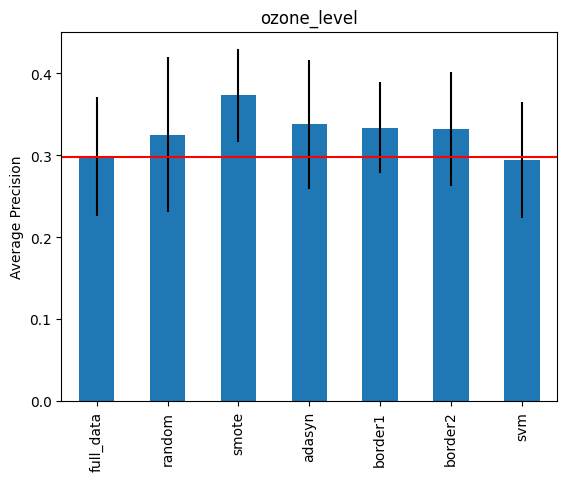

In [11]:
# Now we plot the performance of the model in the 
# left out fold, that was not resampled, from the X_train

for dataset in dataset_ls:
    
    pr_mean_s = pd.Series(pr_mean_dict[dataset])
    pr_std_s = pd.Series(pr_std_dict[dataset])
    
    pr_mean_s.plot.bar(yerr=[pr_std_s, pr_std_s]
        )
    plt.title(dataset)
    plt.ylabel('Average Precision')
    plt.axhline(pr_mean_dict[dataset]['full_data'], color='r')
    plt.show()